# Dev: Catalog for PSF Studies

Here I intend to make a catalog of the Auxtel imaging survey of single exposures. The data is from the latest processed data made by Huan Lin.

More info:
https://confluence.lsstcorp.org/pages/viewpage.action?spaceKey=LSSTCOM&title=AuxTel+Imaging+Survey+Data+Descriptions



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join
from astropy.io.fits import getdata

In [2]:
%matplotlib inline


In [3]:
from datetime import date
date = date.today().strftime("%d%m%Y")
print(f'Today is: {date}')

Today is: 16042024


In [30]:
df = pd.read_csv('../gaia_matched_april2024_PREOPS-4985.csv', index_col=0)

In [31]:
df.columns

Index(['ref_id', 'ref_coord_ra', 'ref_coord_dec', 'ref_phot_g_mean_flux',
       'ref_phot_g_mean_fluxErr', 'ref_centroid_x', 'ref_centroid_y',
       'src_coord_ra', 'src_coord_dec', 'src_base_SdssCentroid_x',
       'src_base_SdssCentroid_y', 'src_base_SdssCentroid_xErr',
       'src_base_SdssCentroid_yErr', 'src_base_SdssShape_instFlux',
       'src_base_SdssShape_instFluxErr', 'src_base_PsfFlux_instFlux',
       'src_base_PsfFlux_instFluxErr',
       'src_base_CircularApertureFlux_3_0_instFlux',
       'src_base_CircularApertureFlux_3_0_instFluxErr',
       'src_base_SdssShape_xx', 'src_base_SdssShape_yy',
       'src_base_SdssShape_xy', 'src_ext_shapeHSM_HsmSourceMoments_xx',
       'src_ext_shapeHSM_HsmSourceMoments_yy',
       'src_ext_shapeHSM_HsmSourceMoments_xy', 'ref_mag_g', 'snr', 'snr_psf',
       'snr_aperture3', 'EL', 'EXPID', 'DATE', 'FILTER', 'EXPTIME', 'fwhm',
       'azimuthPosition', 'mainDoorOpeningPercentage', 'elevation0',
       'azimuth0', 'speed', 'temperature

<Axes: >

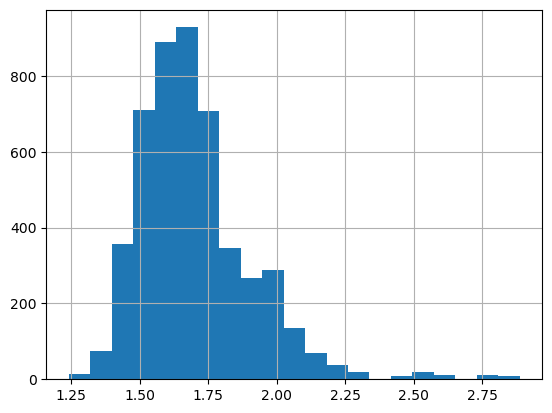

In [37]:
flagG = (df.ref_mag_g>14)&(df.ref_mag_g<17)
flagSNR = (df.snr>50)

flagT = flagG&flagSNR
df.fwhm[flagT].hist(bins=21)

In [9]:
# fnames[-100:]

In [10]:
# import glob
# import pandas as pd

# fnames = glob.glob('../data/gaia_matched_*')
# tables = []
# # for i,fname in enumerate(fnames[:2500]):
# #     df = pd.read_csv(fname, index_col=0)
# #     df['id'] = i
# #     tables.append(df)

In [ ]:
df = pd.concat(tables)
tables = 0

In [ ]:
len(df)

In [ ]:
# help(pd.read_csv)

In [ ]:
a,b = np.unique(df.ref_id, return_counts=True)

In [ ]:
plt.plot(b)

In [109]:
stars = a[b>5]

In [110]:
wstar = np.isin(df.ref_id, stars)
dstar = df.iloc[wstar].copy().reset_index()
# dstar.reset_index(True)

Text(0.5, 0, 'log PSF Flux')

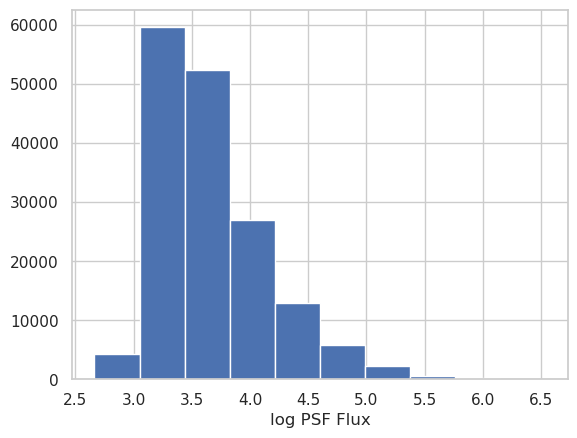

In [111]:
np.log10(dstar.src_base_CircularApertureFlux_3_0_instFlux).hist()
plt.xlabel('log PSF Flux')

Text(0.5, 0, 'log SNR')

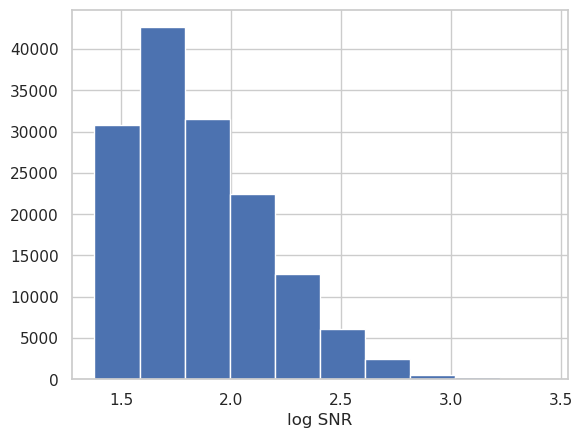

In [112]:
np.log10(dstar.snr).hist()
plt.xlabel('log SNR')

### Compute PSF

In [171]:
dstar['psf_size'] = (dstar['src_base_SdssShape_xx'] + dstar['src_base_SdssShape_yy'])
dstar['fwhm'] = 2.355*np.sqrt(dstar['psf_size'])/10
dstar['fwhm'] = np.where( dstar.fwhm>10, np.nan, dstar.fwhm)
dstar['fwhm'] = np.where( dstar.snr_aperture3<50, np.nan, dstar.fwhm)
dstar['fwhm'] = np.where( np.log10(dstar.src_base_CircularApertureFlux_3_0_instFlux) < 3.5, np.nan, dstar.fwhm)
dstar['fwhm'] = np.where( np.log10(dstar.src_base_CircularApertureFlux_3_0_instFlux) > 5.2, np.nan, dstar.fwhm)
# dstar['fwhm'] = np.where( np.log10(dstar.snr) < 1., np.nan, dstar.fwhm)


In [172]:
# dstar.snr_aperture3

In [173]:
## correct for airmass
airmass = 1/np.cos((90-dstar['EL'])*np.pi/180)
dstar['fwhm_corr'] = dstar['fwhm']*airmass ** (-0.6)


In [174]:
def getFilterSeeingCorrection(filterName):
    """Get the correction factor for seeing due to a filter.

    Parameters
    ----------
    filterName : `str`
        The name of the filter, e.g. 'SDSSg_65mm'.

    Returns
    -------
    correctionFactor : `float`
        The correction factor to apply to the seeing.

    Raises
    ------
        ValueError raised for unknown filters.
    """
    match filterName:
        case "SDSSg_65mm":
            return (474.41 / 500.0) ** 0.2
        case "SDSSr_65mm":
            return (628.47 / 500.0) ** 0.2
        case "SDSSi_65mm":
            return (769.51 / 500.0) ** 0.2
        case "SDSSz_65mm":
            return (871.45 / 500.0) ** 0.2
        case "SDSSy_65mm":
            return (986.8 / 500.0) ** 0.2
        case _:
            return np.nan
            #raise ValueError(f"Unknown filter name: {filterName}")

corr_filter = np.array([getFilterSeeingCorrection(fi) for fi in np.array(dstar.FILTER)])
dstar['fwhm_corr'] *= corr_filter

<Axes: xlabel='FILTER', ylabel='fwhm_corr'>

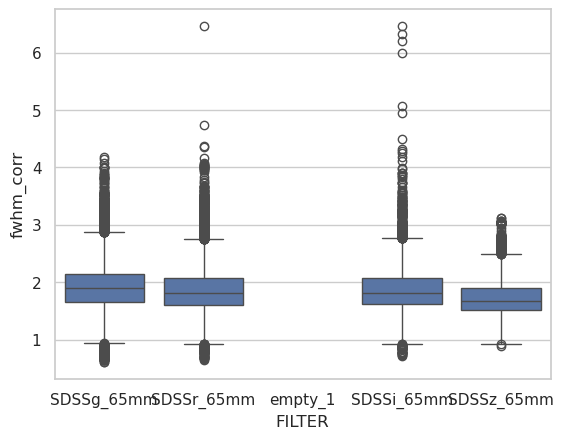

In [175]:
import seaborn as sns

sns.boxplot(x="FILTER", y="fwhm_corr",
            data=dstar)

In [176]:
dstar.columns

Index(['index', 'ref_id', 'ref_coord_ra', 'ref_coord_dec',
       'ref_phot_g_mean_flux', 'ref_phot_g_mean_fluxErr', 'ref_centroid_x',
       'ref_centroid_y', 'src_coord_ra', 'src_coord_dec',
       'src_base_SdssCentroid_x', 'src_base_SdssCentroid_y',
       'src_base_SdssCentroid_xErr', 'src_base_SdssCentroid_yErr',
       'src_base_SdssShape_instFlux', 'src_base_SdssShape_instFluxErr',
       'src_base_PsfFlux_instFlux', 'src_base_PsfFlux_instFluxErr',
       'src_base_CircularApertureFlux_3_0_instFlux',
       'src_base_CircularApertureFlux_3_0_instFluxErr',
       'src_base_SdssShape_xx', 'src_base_SdssShape_yy',
       'src_base_SdssShape_xy', 'src_ext_shapeHSM_HsmSourceMoments_xx',
       'src_ext_shapeHSM_HsmSourceMoments_yy',
       'src_ext_shapeHSM_HsmSourceMoments_xy', 'ref_mag_g', 'snr', 'snr_psf',
       'snr_aperture3', 'EL', 'EXPID', 'DATE', 'FILTER', 'EXPTIME',
       'azimuthPosition', 'mainDoorOpeningPercentage', 'elevation0',
       'azimuth0', 'speed', 'temperatur

In [177]:
dstar['dT_M1_M2'] = dstar.temperatureItem0-dstar.temperatureItem2

In [178]:
cols = ['fwhm_corr', 'sonicTemperatureStdDev', 'dT_M1_M2', 'EL',
        'speed', 'temperatureItem0', 'sonicTemperature']

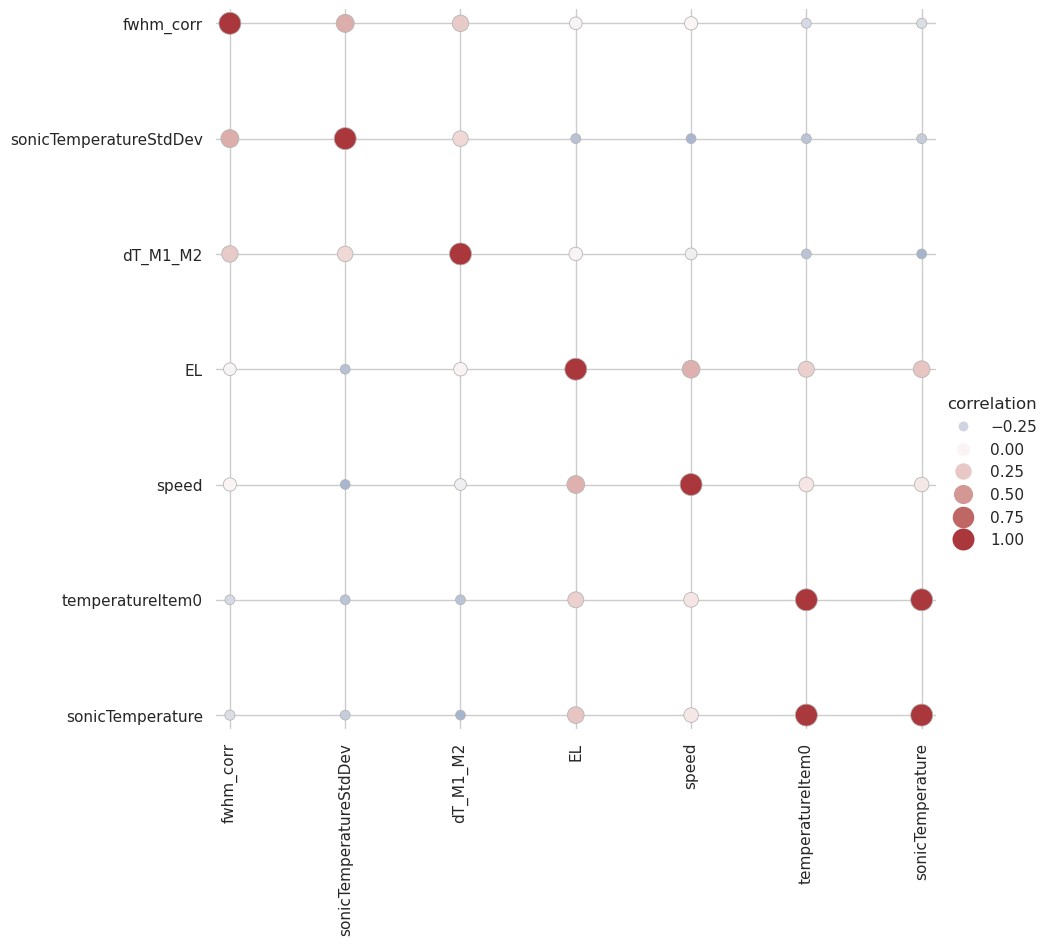

In [179]:
import seaborn as sns
sns.set_theme(style="whitegrid")

df2 = dstar[cols]
# df2.columns = df2.columns.map("-".join)

# Compute a correlation matrix and convert to long-form
corr_mat = df2.corr().stack().reset_index(name="correlation")

# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
# for artist in g.legend.legendHandles:
#     artist.set_edgecolor(".7")

[None]

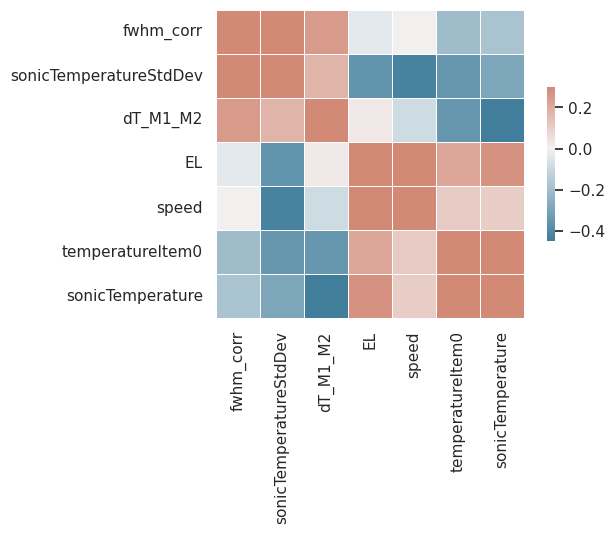

In [180]:
corr = df2.corr()
# Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.margins(.00)
ax.set(aspect="equal")

(0.4, 4.5)

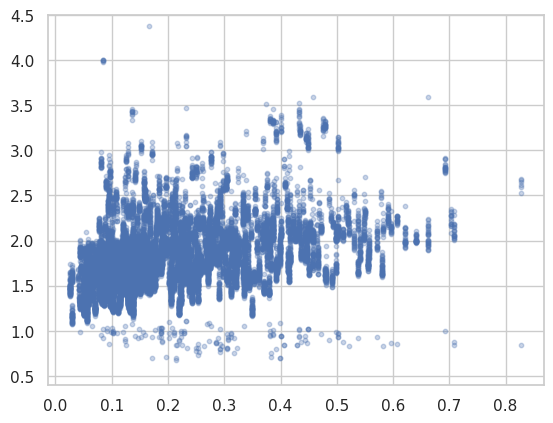

In [181]:
plt.scatter(dstar.sonicTemperatureStdDev, dstar.fwhm_corr, s=10, alpha=0.3)
plt.ylim(0.4, 4.5)

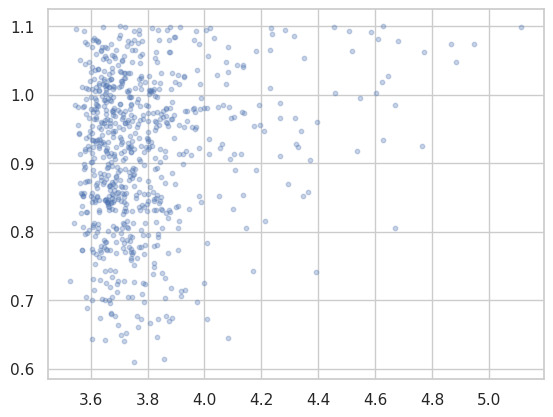

In [182]:
mask = dstar.fwhm_corr<1.1
# plt.scatter(dstar.sonicTemperatureStdDev[mask], dstar.fwhm_corr[mask], s=10, alpha=0.3)
plt.scatter(np.log10(dstar.src_base_CircularApertureFlux_3_0_instFlux)[mask], dstar.fwhm_corr[mask], s=10, alpha=0.3)
# plt.ylim(0.4, 4.5)

/tmp/ipykernel_4468/752496499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['dT_bins'] = pd.cut(df2['dT_M1_M2'], bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], labels=[0, 1, 2, 3, 4])
/tmp/ipykernel_4468/752496499.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df2.groupby('dT_bins')['fwhm_corr'].agg(['mean', 'std'])


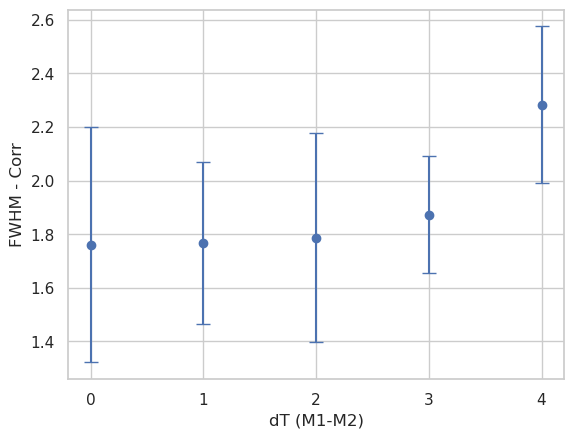

In [183]:
# Bin the x-axis
df2['dT_bins'] = pd.cut(df2['dT_M1_M2'], bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], labels=[0, 1, 2, 3, 4])

# Group by x_bins and calculate mean and std dev
grouped = df2.groupby('dT_bins')['fwhm_corr'].agg(['mean', 'std'])

# Plotting
plt.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], fmt='o', capsize=5)
plt.xlabel('dT (M1-M2)')
plt.ylabel('FWHM - Corr')
# plt.title('Mean and Std Dev as a Function of X')
plt.xticks(range(5), labels=['0', '1', '2', '3', '4'])
plt.grid(True)
plt.show()

/tmp/ipykernel_4468/4011306802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['std_bins'] = pd.cut(df2['sonicTemperatureStdDev'], bins=xbins, labels=[0, 1, 2, 3, 4])
/tmp/ipykernel_4468/4011306802.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df2.groupby('std_bins')['fwhm_corr'].agg(['mean', 'std'])


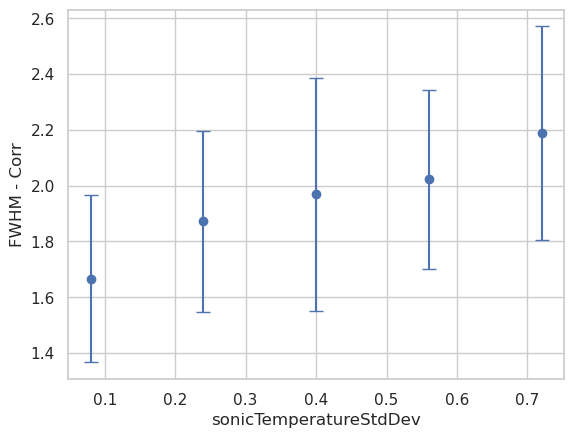

In [184]:
# Bin the x-axis
xbins = np.linspace(0., 0.8, 6)
xmean = 0.5*(xbins[1:]+xbins[:-1])
df2['std_bins'] = pd.cut(df2['sonicTemperatureStdDev'], bins=xbins, labels=[0, 1, 2, 3, 4])

# Group by x_bins and calculate mean and std dev
grouped = df2.groupby('std_bins')['fwhm_corr'].agg(['mean', 'std'])

# Plotting
plt.errorbar(xmean, grouped['mean'], yerr=grouped['std'], fmt='o', capsize=5)
plt.xlabel('sonicTemperatureStdDev')
plt.ylabel('FWHM - Corr')
# plt.title('Mean and Std Dev as a Function of X')
# plt.xticks(range(5), labels=['0', '1', '2', '3', '4'])
plt.grid(True)
plt.show()

In [185]:
import numpy as np
import statsmodels.api as sm

def fit_poly(x1, x2, yp):
    #mask = np.isnan(x1)|np.isnan(x2)|np.isnan(yp)
    mask = ~np.isnan(x1) & ~np.isnan(x2) & ~np.isnan(yp)

    # Create the design matrix
    y = yp[mask]
    X = np.column_stack((x1[mask], x2[mask]))
    X = sm.add_constant(X)  # Adding a constant term for intercept
    
    # Fit the linear model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Print the summary of the fitted model
    print(results.summary())
    return results

def plot_fit_poly(x1,x2,y):
    ## make fit
    results =  fit_poly(x1, x2, y)

    x1n = np.linspace(np.nanmin(x1),np.nanmax(x1), 100)
    x2n = np.linspace(np.nanmin(x2),np.nanmax(x2), 100)
    
    X = np.column_stack([x1n, x2n])
    X = sm.add_constant(X)  # Adding a constant term for intercept

    y_pred = results.predict(X)
    ix = np.argsort(y_pred)
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Scatter plot of x1 vs y
    axes[0].scatter(x1, y, label='Actual data', color='blue')
    axes[0].plot(x1n, y_pred, label='Predicted values', color='red')
    #axes[0].plot(x1[ix], y_pred[ix], label='Fitted line', color='green')
    axes[0].set_xlabel('sonicTemperatureStdDev')
    axes[0].set_ylabel('Y')
    axes[0].set_title('sonicTemperatureStdDev vs Y')
    axes[0].legend()
    axes[0].grid(True)
    
    # Scatter plot of x2 vs y
    axes[1].scatter(x2, y, label='Actual data', color='blue')
    axes[1].plot(x2n, y_pred, label='Predicted values', color='red')
    #axes[1].plot(x2[ix], y_pred[ix], label='Fitted line', color='green')
    axes[1].set_xlabel('M1-M2')
    axes[1].set_ylabel('Y')
    axes[1].set_title('M1-M2 vs Y')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     2574.
Date:                Fri, 05 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:13:54   Log-Likelihood:                -5485.9
No. Observations:               19976   AIC:                         1.098e+04
Df Residuals:                   19973   BIC:                         1.100e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4387      0.006    240.759      0.0

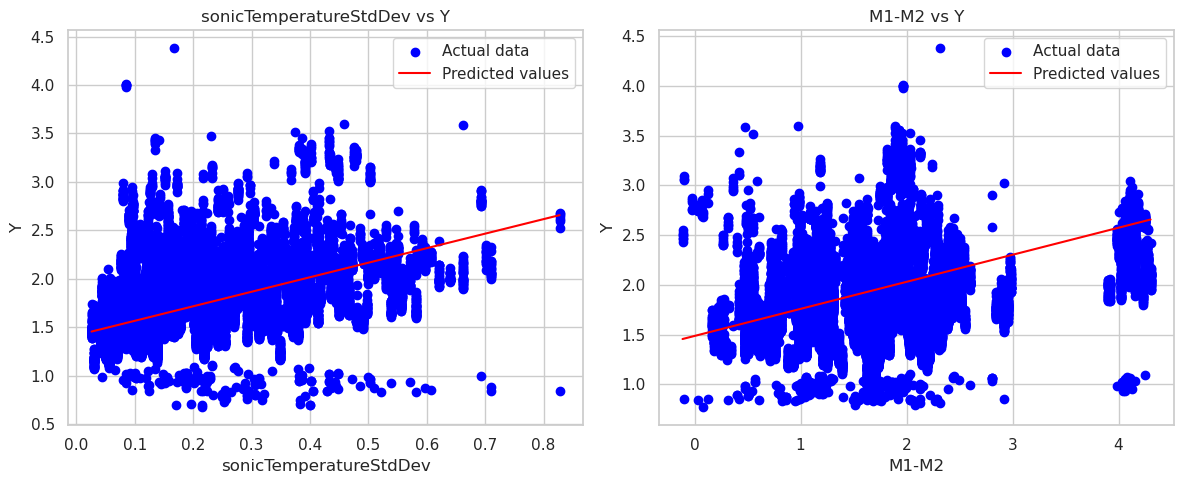

In [186]:
plot_fit_poly(np.array(dstar.sonicTemperatureStdDev), np.array(dstar.dT_M1_M2), np.array(dstar.fwhm_corr))

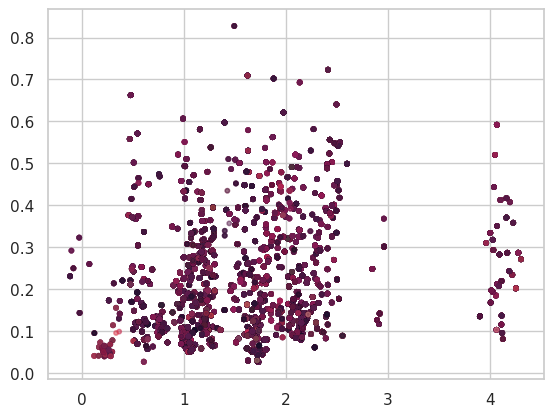

In [187]:
plt.scatter(dstar.dT_M1_M2, dstar.sonicTemperatureStdDev, s=10, alpha=0.3, c=np.log10(dstar.snr))
# plt.ylim(0.4, 4.5)


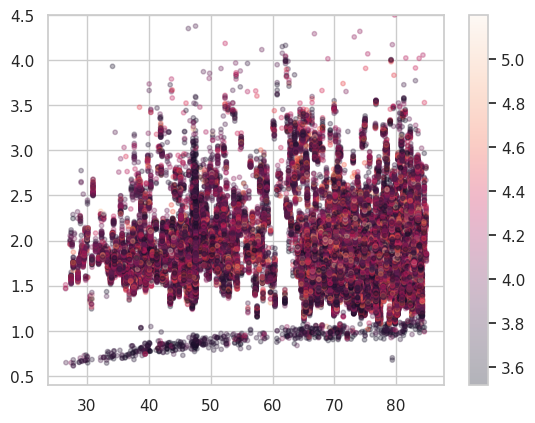

In [188]:
plt.scatter(dstar.elevation0, dstar.fwhm_corr, s=10, alpha=0.3, c=np.log10(dstar.src_base_CircularApertureFlux_3_0_instFlux))
plt.ylim(0.4, 4.5)
plt.colorbar()
# plt.show()

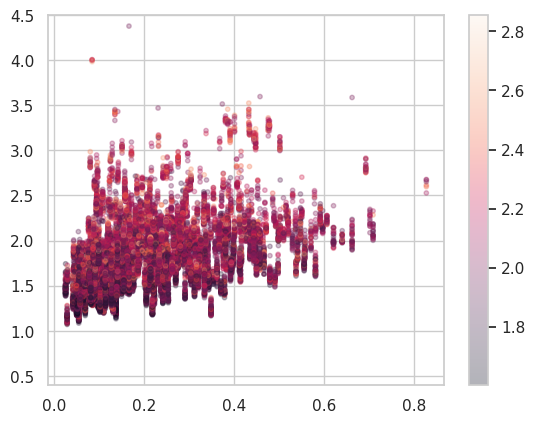

In [189]:
plt.scatter(dstar.sonicTemperatureStdDev, dstar.fwhm_corr, s=10, alpha=0.3, c=np.log10(dstar.snr))
plt.ylim(0.4, 4.5)
plt.colorbar()
# plt.show()

<Axes: xlabel='FILTER', ylabel='fwhm_corr'>

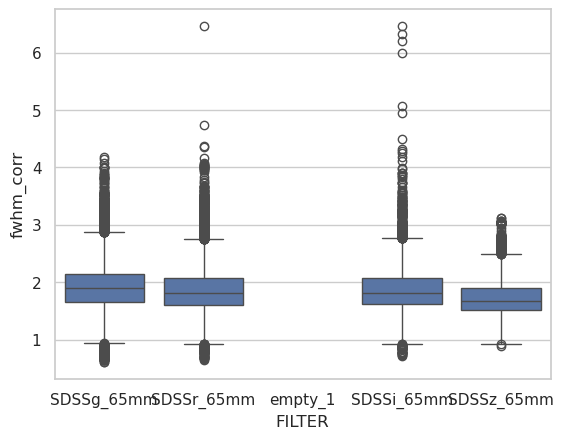

In [190]:
import seaborn as sns

sns.boxplot(x="FILTER", y="fwhm_corr",
            data=dstar)


<Axes: >

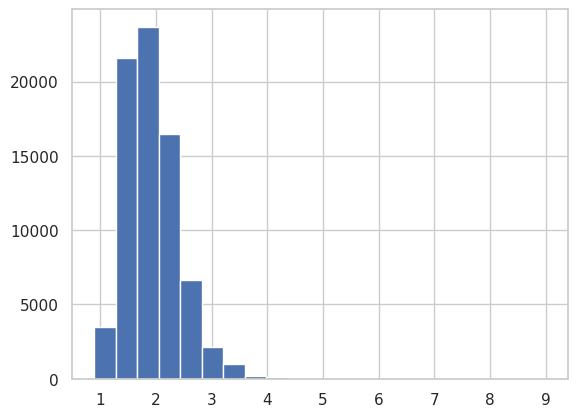

In [191]:
dstar.fwhm.hist(bins=21)

In [68]:
# times = np.array(dstar.DATE).astype(np.datetime64)

In [69]:
from astropy.time import Time

times = Time(np.array(dstar.DATE).astype(np.datetime64), scale='utc')


In [97]:
fullPath = ['lsst.sal.ESS.airTurbulence.sonicTemperature',
           # 'lsst.sal.ESS.temperature.Air',
           # 'lsst.sal.ESS.temperature.M2',
           # 'lsst.sal.ESS.temperature.Truss',
           'lsst.sal.ATDome.position.azimuthPosition',
           'lsst.sal.ESS.airTurbulence.sonicTemperatureStdDev',
           'lsst.sal.ATDome.position.mainDoorOpeningPercentage',
           'lsst.sal.ESS.airTurbulence.sonicTemperatureStdDev',
           # 'lsst.sal.ESS.airTurbulence.Headwind',
           # 'lsst.sal.ESS.airTurbulence.Crosswind',
           'lsst.sal.ATMCS.trajectory.elevation0',
           'lsst.sal.ATMCS.trajectory.azimuth0',
           'lsst.sal.ESS.airTurbulence.speed0',
           'lsst.sal.ESS.airTurbulence.speed1',
           'lsst.sal.ESS.airTurbulence.speed2',
           # 'lsst.sal.ESS.temperature.M2 minus Air temp',
           'lsst.sal.ESS.airFlow.speed',
           'lsst.sal.ESS.temperature.temperatureItem0',
           'lsst.sal.ESS.temperature.temperatureItem1',
           'lsst.sal.ESS.temperature.temperatureItem2',
           'lsst.sal.ESS.temperature.temperatureItem3',
           'lsst.sal.ESS.temperature.temperatureItem4',
          ]

paths = []
cols = []
for col in fullPath:
    paths.append(('.').join(col.split('.')[:-1]))
    cols.append(col.split('.')[-1])

import numpy as np
columns = np.array(cols)
upaths = np.unique(paths) 
out = dict().fromkeys(upaths)
for path in upaths:
    out[path] = columns[np.array(paths)==path]
out    

{'lsst.sal.ATDome.position': array(['azimuthPosition', 'mainDoorOpeningPercentage'], dtype='<U25'),
 'lsst.sal.ATMCS.trajectory': array(['elevation0', 'azimuth0'], dtype='<U25'),
 'lsst.sal.ESS.airFlow': array(['speed'], dtype='<U25'),
 'lsst.sal.ESS.airTurbulence': array(['sonicTemperature', 'sonicTemperatureStdDev',
        'sonicTemperatureStdDev', 'speed0', 'speed1', 'speed2'],
       dtype='<U25'),
 'lsst.sal.ESS.temperature': array(['temperatureItem0', 'temperatureItem1', 'temperatureItem2',
        'temperatureItem3', 'temperatureItem4'], dtype='<U25')}

In [194]:
thermalProperties = {'lsst.sal.ATDome.position': ['azimuthPosition', 'mainDoorOpeningPercentage'],
               'lsst.sal.ATMCS.trajectory': ['elevation0', 'azimuth0'],
               'lsst.sal.ESS.airFlow': ['speed'],
               'lsst.sal.ESS.airTurbulence':['sonicTemperature', 'sonicTemperatureStdDev',
                    'sonicTemperatureStdDev', 'speed0', 'speed1', 'speed2'],
               'lsst.sal.ESS.temperature': ['temperatureItem0', 'temperatureItem1', 'temperatureItem2',
                    'temperatureItem3', 'temperatureItem4']
            }

In [150]:
from astropy.time import Time,TimeDelta
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
client = makeEfdClient()

def get_efd(times):
    delta_t = 30
    dt = TimeDelta(delta_t, format='sec')
    tables = [] 
    for now in times:
        vals = []
        for path, col in zip(out.keys(),out.values()):
            df = getEfdData(client, path, columns=col, prePadding=5, begin=now, timespan=dt, warn=False)
            vals.append(df.mean())
        df2 = pd.DataFrame(pd.concat(vals,axis=0)).T
        tables.append(df2)
    return pd.concat(tables,ignore_index=True)

In [153]:
efd_data = get_efd(times)

In [182]:
pd.concat([dstar,efd_data],axis=1)

,index,ref_id,ref_coord_ra,ref_coord_dec,ref_phot_g_mean_flux,ref_phot_g_mean_fluxErr,ref_centroid_x,ref_centroid_y,src_coord_ra,src_coord_dec,...,temperatureItem1,temperatureItem2,temperatureItem3,temperatureItem4,sonicTemperature,sonicTemperatureStdDev,sonicTemperatureStdDev_1,speed0,speed1,speed2
0,30,5544608650924893568,2.138389,-0.631662,847279.02454,397.244428,2936.497385,1198.028258,2.138389,-0.631662,...,15.545223,15.316121,16.276402,17.225477,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5544608650924893568,2.138389,-0.631662,847279.02454,397.244428,863.285646,197.639466,2.138389,-0.631662,...,7.803752,7.582218,7.586363,8.555476,6.883180,0.228647,0.228647,-0.330415,-0.107915,-0.194945
2,74,5544608650924893568,2.138389,-0.631662,847279.02454,397.244428,862.171178,3171.291271,2.138389,-0.631662,...,7.742253,7.514452,7.737479,8.651531,NaN,NaN,NaN,NaN,NaN,NaN
3,33,5544608650924893568,2.138389,-0.631662,847279.02454,397.244428,3421.101277,1237.023039,2.138389,-0.631662,...,11.497723,11.300987,12.209270,13.332831,10.849930,0.164674,0.164674,-0.108775,-0.306440,-0.033010
4,28,5544608650924893568,2.138389,-0.631662,847279.02454,397.244428,2377.076199,1025.479697,2.138389,-0.631662,...,14.417173,14.614515,15.074547,16.025510,NaN,NaN,NaN,NaN,NaN,NaN
5,55,5544608650924893568,2.138389,-0.631662,847279.02454,397.244428,1119.271048,2629.152759,2.138389,-0.631662,...,14.224498,14.094728,14.887479,16.156292,14.205105,0.251277,0.251277,-0.226475,0.002530,-0.082185
6,51,5544608650924893568,2.138389,-0.631662,847279.02454,397.244428,2342.349475,2365.657545,2.138389,-0.631662,...,14.626516,14.736579,14.481443,15.029298,NaN,NaN,NaN,NaN,NaN,NaN
7,45,5544608650924893568,2.138389,-0.631662,847279.02454,397.244428,3049.290334,1324.916774,2.138389,-0.631662,...,12.783293,12.782100,12.482005,13.088550,12.334350,0.094668,0.094668,-0.171980,-0.176865,0.047280
8,3,5544608650924893568,2.138389,-0.631662,847279.02454,397.244428,2989.987509,163.630623,2.138389,-0.631662,...,11.250108,11.134687,12.073270,13.460085,11.164870,0.222785,0.222785,-0.251325,-0.075335,0.037700
9,30,5544608650924893568,2.138389,-0.631662,847279.02454,397.244428,1834.866642,1632.917528,2.138389,-0.631662,...,11.212280,11.062672,12.192336,13.558352,11.105880,0.400996,0.400996,-0.161570,-0.022070,0.063515


In [195]:
help(makeEfdClient)

Help on function makeEfdClient in module lsst.summit.utils.efdUtils:

makeEfdClient(testing=False)
    Automatically create an EFD client based on the site.
    
    Parameters
    ----------
    testing : `bool`, optional
        Set to ``True`` if running in a test suite. This will default to using
        the USDF EFD, for which data has been recorded for replay by the ``vcr`
        package. Note data must be re-recorded to ``vcr`` from both inside and
        outside the USDF when the package/data changes, due to the use of a
        proxy meaning that the web requests are different depending on whether
        the EFD is being contacted from inside and outside the USDF.
    
    Returns
    -------
    efdClient : `lsst_efd_client.efd_helper.EfdClient`
        The EFD client to use for the current site.



In [178]:
# pd.merge(dstar, efd_data, on='index', how='inner')


In [180]:
len(dstar)

55

In [181]:
len(efd_data)

55

In [183]:
dstar.columns

Index(['index', 'ref_id', 'ref_coord_ra', 'ref_coord_dec',
       'ref_phot_g_mean_flux', 'ref_phot_g_mean_fluxErr', 'ref_centroid_x',
       'ref_centroid_y', 'src_coord_ra', 'src_coord_dec',
       'src_base_SdssCentroid_x', 'src_base_SdssCentroid_y',
       'src_base_SdssCentroid_xErr', 'src_base_SdssCentroid_yErr',
       'src_base_SdssShape_instFlux', 'src_base_SdssShape_instFluxErr',
       'src_base_PsfFlux_instFlux', 'src_base_PsfFlux_instFluxErr',
       'src_base_CircularApertureFlux_3_0_instFlux',
       'src_base_CircularApertureFlux_3_0_instFluxErr',
       'src_base_SdssShape_xx', 'src_base_SdssShape_yy',
       'src_base_SdssShape_xy', 'src_ext_shapeHSM_HsmSourceMoments_xx',
       'src_ext_shapeHSM_HsmSourceMoments_yy',
       'src_ext_shapeHSM_HsmSourceMoments_xy', 'EXPID', 'DATE', 'FILTER',
       'EXPTIME', 'id'],
      dtype='object')

## Butler Acess

Before querying the data we should understand what is inside the collection.

In [12]:
import lsst.daf.butler as dafButler
 
collections=['LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871']
 
butler = dafButler.Butler('/repo/embargo',collections=collections)
registry = butler.registry

In [17]:
dataset_refs = list(registry.queryDatasets('calexp', collections=collections))
dataset_refs = sorted(dataset_refs, key=lambda x : x.dataId['visit'])
expIds = [int(ref.dataId['visit']) for ref in dataset_refs]
print(f'There are {len(expIds)} exposures')

There are 4041 exposures


In [18]:
for dtp in registry.queryDatasetTypes():
    if 'src' in dtp.name:
        print(dtp)

DatasetType('src_schema', {}, SourceCatalog)
DatasetType('src', {band, instrument, detector, physical_filter, visit}, SourceCatalog)
DatasetType('srcMatchFull', {band, instrument, detector, physical_filter, visit}, Catalog)
DatasetType('srcMatch', {band, instrument, detector, physical_filter, visit}, Catalog)
DatasetType('finalized_src_table', {band, instrument, physical_filter, visit}, DataFrame)
DatasetType('deepCoadd_forced_src_schema', {}, SourceCatalog)
DatasetType('deepCoadd_forced_src', {band, skymap, tract, patch}, SourceCatalog)
DatasetType('forced_src_schema', {}, SourceCatalog)
DatasetType('forced_src', {band, instrument, skymap, detector, physical_filter, tract, visit}, SourceCatalog)
DatasetType('forced_src_diaObject', {band, instrument, skymap, detector, physical_filter, tract, visit}, SourceCatalog)
DatasetType('forced_src_diaObject_schema', {}, SourceCatalog)


In [19]:
scr = butler.get('srcMatchFull', visit=expIds[0], detector=0, collections=collections[0]).asAstropy()
scr

ref_id,ref_coord_ra,ref_coord_dec,ref_phot_g_mean_flux,ref_anyFilterMapsToThis,ref_phot_bp_mean_flux,ref_phot_rp_mean_flux,ref_phot_g_mean_fluxErr,ref_anyFilterMapsToThisErr,ref_phot_bp_mean_fluxErr,ref_phot_rp_mean_fluxErr,ref_coord_raErr,ref_coord_decErr,ref_epoch,ref_pm_ra,ref_pm_dec,ref_pm_raErr,ref_pm_decErr,ref_pm_flag,ref_parallax,ref_parallaxErr,ref_parallax_flag,ref_coord_ra_coord_dec_Cov,ref_coord_ra_pm_ra_Cov,ref_coord_ra_pm_dec_Cov,ref_coord_ra_parallax_Cov,ref_coord_dec_pm_ra_Cov,ref_coord_dec_pm_dec_Cov,ref_coord_dec_parallax_Cov,ref_pm_ra_pm_dec_Cov,ref_pm_ra_parallax_Cov,ref_pm_dec_parallax_Cov,ref_astrometric_excess_noise,ref_centroid_x,ref_slot_Centroid_x,ref_centroid_y,ref_slot_Centroid_y,ref_hasCentroid,src_id,src_coord_ra,src_coord_dec,src_parent,src_calib_detected,src_calib_psf_candidate,src_calib_psf_used,src_calib_psf_reserved,src_coord_raErr,src_coord_decErr,src_coord_ra_dec_Cov,src_deblend_nChild,src_deblend_deblendedAsPsf,src_deblend_psfCenter_x,src_deblend_psfCenter_y,src_deblend_psf_instFlux,src_deblend_tooManyPeaks,src_deblend_parentTooBig,src_deblend_masked,src_deblend_failed,src_deblend_skipped,src_deblend_rampedTemplate,src_deblend_patchedTemplate,src_deblend_hasStrayFlux,src_deblend_peak_center_x,src_deblend_peak_center_y,src_deblend_peakId,src_deblend_nPeaks,src_deblend_parentNPeaks,src_sky_source,src_base_NaiveCentroid_x,src_base_NaiveCentroid_y,src_base_NaiveCentroid_flag,src_base_NaiveCentroid_flag_noCounts,src_base_NaiveCentroid_flag_edge,src_base_NaiveCentroid_flag_resetToPeak,src_base_SdssCentroid_x,src_slot_Centroid_x,src_base_SdssCentroid_y,src_slot_Centroid_y,src_base_SdssCentroid_xErr,src_slot_Centroid_xErr,src_base_SdssCentroid_yErr,src_slot_Centroid_yErr,src_base_SdssCentroid_flag,src_base_CircularApertureFlux_flag_badCentroid,src_base_GaussianFlux_flag_badCentroid,src_base_LocalBackground_flag_badCentroid,src_base_NaiveCentroid_flag_badInitialCentroid,src_base_PsfFlux_flag_badCentroid,src_base_SdssShape_flag_badCentroid,src_base_Variance_flag_badCentroid,src_ext_photometryKron_KronFlux_flag_badInitialCentroid,src_ext_shapeHSM_HigherOrderMomentsPSF_flag_badCentroid,src_ext_shapeHSM_HsmPsfMomentsDebiased_flag_badCentroid,src_ext_shapeHSM_HsmPsfMoments_flag_badCentroid,src_ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,src_ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid,src_ext_shapeHSM_HsmSourceMoments_flag_badCentroid,src_slot_Centroid_flag,src_base_SdssCentroid_flag_edge,src_base_CircularApertureFlux_flag_badCentroid_edge,src_base_GaussianFlux_flag_badCentroid_edge,src_base_LocalBackground_flag_badCentroid_edge,src_base_NaiveCentroid_flag_badInitialCentroid_edge,src_base_PsfFlux_flag_badCentroid_edge,src_base_SdssShape_flag_badCentroid_edge,src_base_Variance_flag_badCentroid_edge,src_ext_photometryKron_KronFlux_flag_badInitialCentroid_edge,src_ext_shapeHSM_HigherOrderMomentsPSF_flag_badCentroid_edge,src_ext_shapeHSM_HsmPsfMomentsDebiased_flag_badCentroid_edge,src_ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,src_ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,src_ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_edge,src_ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,src_slot_Centroid_flag_edge,src_base_SdssCentroid_flag_noSecondDerivative,src_base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,src_base_GaussianFlux_flag_badCentroid_noSecondDerivative,src_base_LocalBackground_flag_badCentroid_noSecondDerivative,src_base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,src_base_PsfFlux_flag_badCentroid_noSecondDerivative,src_base_SdssShape_flag_badCentroid_noSecondDerivative,src_base_Variance_flag_badCentroid_noSecondDerivative,src_ext_photometryKron_KronFlux_flag_badInitialCentroid_noSecondDerivative,src_ext_shapeHSM_HigherOrderMomentsPSF_flag_badCentroid_noSecondDerivative,src_ext_shapeHSM_HsmPsfMomentsDebiased_flag_badCentroid_noSecondDerivative,src_ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative,src_ext_shapeHSM_HsmShapeRegauss_

In [26]:
import astropy.units as u
scr['ref_phot_g_mean_fluxErr'].to(u.ABmag)

<Magnitude [23.87843981, 24.56692469, 24.3370974 , 25.04152411,
            24.22013971, 25.15095649, 23.36879792, 24.72449732,
            25.09450987, 25.26271917, 23.69922869, 25.14198958,
            24.44759105, 23.54712368, 25.05856363, 24.66415669,
            25.09723464, 25.16658229, 24.87122114, 25.03909021,
            23.86492361, 24.97378456, 24.14537667, 23.96052535,
            21.78045834, 25.27941118, 25.2642555 , 23.96833953,
            24.84248189, 24.69016196, 24.73859485, 25.02651521,
            24.75234526, 24.68333015, 25.12798339] mag(AB)>

In [45]:
# scr.to_pandas().to_csv('bla')

In [41]:
# objectTable = butler.get('deepCoaddVisits', dataId=dataIds[0])
# objectTable

# # 'objectTable_tract_gaia_dr2_20200414_match'

In [42]:
# # Display the available dataset types
# for d in sorted(registry.queryDatasetTypes()): print(d.name)


In [30]:
columns = ['ref_id','ref_coord_ra','ref_coord_dec','ref_phot_g_mean_flux','ref_phot_g_mean_fluxErr']
columns+= ['ref_centroid_x','ref_centroid_y']

columns+= ['src_base_SdssCentroid_x','src_base_SdssCentroid_y','src_base_SdssCentroid_xErr','src_base_SdssCentroid_yErr']
columns+= ['src_base_SdssShape_instFlux','src_base_SdssShape_instFluxErr']
columns+= ['base_CircularApertureFlux_3_0_instFlux','base_CircularApertureFlux_3_0_instFluxErr']
columns+= ['src_base_PsfFlux_instFlux','src_base_PsfFlux_instFluxErr']


In [32]:
columns = list(scr.columns)
for col in columns:
    if 'ra' in col:
        print(col)

ref_coord_ra
ref_coord_raErr
ref_pm_ra
ref_pm_raErr
ref_parallax
ref_parallaxErr
ref_parallax_flag
ref_coord_ra_coord_dec_Cov
ref_coord_ra_pm_ra_Cov
ref_coord_ra_pm_dec_Cov
ref_coord_ra_parallax_Cov
ref_coord_dec_pm_ra_Cov
ref_coord_dec_parallax_Cov
ref_pm_ra_pm_dec_Cov
ref_pm_ra_parallax_Cov
ref_pm_dec_parallax_Cov
src_coord_ra
src_coord_raErr
src_coord_ra_dec_Cov
src_deblend_rampedTemplate
src_deblend_hasStrayFlux
src_base_Blendedness_raw
src_base_Blendedness_raw_child_instFlux
src_base_Blendedness_raw_parent_instFlux
src_base_Blendedness_raw_child_xx
src_base_Blendedness_raw_child_yy
src_base_Blendedness_raw_child_xy
src_base_Blendedness_raw_parent_xx
src_base_Blendedness_raw_parent_yy
src_base_Blendedness_raw_parent_xy
src_ext_shapeHSM_HsmPsfMoments_flag_invalid_param
src_slot_PsfShape_flag_invalid_param
src_ext_shapeHSM_HsmSourceMoments_flag_invalid_param
src_base_GaussianFlux_flag_badShape_invalid_param
src_slot_Shape_flag_invalid_param
src_ext_shapeHSM_HsmSourceMomentsRound_flag

In [224]:
df = pd.read_csv('../data/gaia_matched_2023120500506.csv', index_col=0)

In [225]:
df.columns

Index(['ref_id', 'ref_coord_ra', 'ref_coord_dec', 'ref_phot_g_mean_flux',
       'ref_phot_g_mean_fluxErr', 'ref_centroid_x', 'ref_centroid_y',
       'src_coord_ra', 'src_coord_dec', 'src_base_SdssCentroid_x',
       'src_base_SdssCentroid_y', 'src_base_SdssCentroid_xErr',
       'src_base_SdssCentroid_yErr', 'src_base_SdssShape_instFlux',
       'src_base_SdssShape_instFluxErr', 'src_base_PsfFlux_instFlux',
       'src_base_PsfFlux_instFluxErr',
       'src_base_CircularApertureFlux_3_0_instFlux',
       'src_base_CircularApertureFlux_3_0_instFluxErr',
       'src_base_SdssShape_xx', 'src_base_SdssShape_yy',
       'src_base_SdssShape_xy', 'src_ext_shapeHSM_HsmSourceMoments_xx',
       'src_ext_shapeHSM_HsmSourceMoments_yy',
       'src_ext_shapeHSM_HsmSourceMoments_xy', 'EXPID', 'DATE', 'FILTER',
       'EXPTIME'],
      dtype='object')

In [192]:
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

client = makeEfdClient()